Imports

In [1]:
import numpy as np
import random
from pysat.solvers import Solver
from collections import deque
from scipy.ndimage import label
from scipy.spatial import distance
import matplotlib.pyplot as plt
import itertools 
import z3
import json

Task 1: Generate puzzles

1.1 define puzzle representations

using a 2D array , matrix grid where it is NxN grid size. 

(A-Z) is for the region labels
( * ) is for when a star is present in the grid


In [2]:
#example with 5x5 grid 1 star per row/column/region
puzzle = [
 ['A', 'B', 'C', 'C', 'C'],
 ['A', 'B', 'C', 'C', 'D'],
 ['A', 'A', 'C', 'D', 'D'],
 ['E', 'C', 'C', 'D', 'D'],
 ['E', 'E', 'E', 'D', 'D']
 ]

solution = [
 ['0', '1', '0', '0', '0'],
 ['0', '0', '0', '1', '0'],
 ['1', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '1'],
 ['0', '0', '1', '0', '0']
]
# example from puzzle-star-battle.com solved by myself

Visualiser

In [3]:
#visualiser

def visualize_star_battle(puzzle, solution):
    size = len(puzzle)
    
    # Convert NumPy array to list if necessary
    if isinstance(solution, np.ndarray):
        solution = solution.tolist()

    fig, ax = plt.subplots(figsize=(5, 5))

    # Create a grid
    for x in range(size + 1):
        ax.plot([x, x], [0, size], 'k', lw=1)  # Vertical lines
        ax.plot([0, size], [x, x], 'k', lw=1)  # Horizontal lines

    # Fill in regions with colors
    region_colors = {}
    color_map = plt.cm.tab20c
    unique_regions = sorted(set(cell for row in puzzle for cell in row))
    
    for idx, region in enumerate(unique_regions):
        region_colors[region] = color_map(idx / len(unique_regions))

    for i in range(size):
        for j in range(size):
            region = puzzle[i][j]
            ax.add_patch(plt.Rectangle((j, size - i - 1), 1, 1, color=region_colors[region], alpha=0.5))
            
            # Check integer 1 instead of string '1'
            if solution[i][j] == 1:
                ax.text(j + 0.5, size - i - 0.5, '★', fontsize=16, ha='center', va='center', color='black')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_frame_on(False)

    plt.show()

# visualize_star_battle(puzzle, solution)


1.2 Constraint representations

each row contains only k stars 
each column contains only k stars 
each region contains only k stars
no two stars can be adjacent



find values about puzzle

In [4]:
def get_star_limit(grid_size):
    if grid_size == 5:
        return 1
    elif grid_size == 6:
        return 1
    elif grid_size == 8:
        return 1
    elif grid_size == 10:
        return 2
    elif grid_size == 14:
        return 3
    else:
        raise ValueError(f"Grid size {grid_size} not supported")

Validate puzzles

In [5]:
def validate_solution(puzzle,solution):
    #get number of stars for grid size of puzzle
    grid_size =len(puzzle)
    star_lim = get_star_limit(grid_size)

    unique_regions = set(cell for row in puzzle for cell in row)

    # number of regions matches the grid size
    if len(unique_regions) != grid_size:
        print("num regions doesnt match grid size")
        return False

    #track star counts in row, column, region
    row_counts = np.zeros(len(puzzle), dtype = int)
    col_counts = np.zeros(len(puzzle[0]),dtype=int)
    region_counts = {region: 0 for region in set([item for sublist in puzzle for item in sublist])}

    # check puzzle and solution dimentions match
    if len(puzzle) != len(solution) or len(puzzle[0]) != len(solution):
        print("puzle dimensions dont match")
        return False
    
    for r in range(grid_size):
        for c in range(grid_size):
            if solution[r][c] == '1':
                row_counts[r]+=1
                col_counts[c]+=1
                region = puzzle[r][c]

                #count stars in region
                if region not in region_counts:
                    region_counts[region]=0
                region_counts[region]+=1
    
    # check each row,column,region has exactly n stars 
    if not (all(count == star_lim for count in row_counts) and
            all(count == star_lim for count in col_counts) and
            all(count == star_lim for count in region_counts.values())):
        print("row col or region wrong no stars")
        return False
    
    #ensure stars dont touch diagnoally
    for r in range(grid_size):
        for c in range(grid_size):
            if solution[r][c] == '1':
                # check adjacent cells for stars
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue
                        nr, nc = r + dr, c + dc
                        if 0 <= nr < len(puzzle) and 0 <= nc < len(puzzle[0]):
                            if solution[nr][nc] == '1':
                                print("stars touch horizontal")
                                return False
                            
    return True

In [6]:
#checking this works
valid = validate_solution(puzzle,solution)
print("solution?", valid)

solution? True


Some example puzzles to test 

In [7]:
#example puzzles 
puzzle_5x5 = [
    ['A', 'B', 'C', 'D', 'E'],
    ['A', 'B', 'C', 'D', 'F'],
    ['A', 'B', 'C', 'G', 'F'],
    ['A', 'H', 'C', 'G', 'F'],
    ['I', 'H', 'C', 'G', 'F']
]

solution_5x5 = [
    ['0', '0', '0', '1', '0'],
    ['0', '0', '1', '0', '0'],
    ['0', '0', '0', '0', '1'],
    ['1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0']
]

puzzle_10x10 = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
]

solution_10x10 = [
    ['0', '1', '0', '0', '1', '0', '0', '0', '0', '0'],
    ['1', '0', '0', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '1', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '1', '0', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '0', '1', '0']
]

puzzle_14x14 = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
]

solution_14x14 = [
    ['0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0'],
    ['1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0'],
    ['0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0'],
    ['0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0'],
    ['0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0'],
    ['1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0']
]


In [8]:
print(validate_solution(puzzle_5x5,solution_5x5),
      validate_solution(puzzle_10x10, solution_10x10),
      validate_solution(puzzle_14x14, solution_14x14))

num regions doesnt match grid size
row col or region wrong no stars
row col or region wrong no stars
False False False


1.3 Basic Generation Algorithm using sat solver

In [9]:
def validate_stars(grid, star_lim):
    size = len(grid)
    
    # Check each column has exact num stars
    if not all(np.sum(grid[:, col]) == star_lim for col in range(size)):
        return False

    # Check no adjacent stars
    for r in range(size):
        for c in range(size):
            if grid[r, c] == 1:
                #directons orthogonal
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if (dr == 0 and dc == 0) or not (0 <= r + dr < size and 0 <= c + dc < size):
                            continue
                        if grid[r + dr, c + dc] == 1:
                            return False
    return True

In [10]:
def adjacent_star(grid, r, c):
    size = len(grid)
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            nr, nc = r + dr, c + dc
            if 0 <= nr < size and 0 <= nc < size and grid[nr, nc] == 1:
                return True
    return False

In [11]:
#start
def generate_star_solution(size):
    star_lim = get_star_limit(size)
    grid = np.zeros((size, size), dtype=int)

    # available positions per column to check exact star limits
    column_counts = [0] * size
    
    for row in range(size):
        valid_positions = list(range(size))
        random.shuffle(valid_positions)  
        stars_placed = 0

        for col in valid_positions:
            # check column limit and adjacency
            if column_counts[col] < star_lim and not adjacent_star(grid, row, col):
                grid[row, col] = 1
                column_counts[col] += 1
                stars_placed += 1
                if stars_placed == star_lim:
                    break

    # validate
    if not validate_stars(grid, star_lim):
        return generate_star_solution(size)  # Retry in rare failure cases

    return grid

In [12]:
# check first secton
solution1 = generate_star_solution(5)

print(solution1)


[[0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]


regions

In [13]:
def generate_regions(solution):
    grid_size = solution.shape[0]

    # get star positions
    stars = [(r, c) for r in range(grid_size) for c in range(grid_size) if solution[r, c] == 1]

    # initialize region map with -1 (unassigned cells)
    region_map = -np.ones((grid_size, grid_size), dtype=int)

    # directions in order left, right, up, down
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # assign each star a unique region number and initialize expansion queue
    expansion_queue = []
    for region_id, (r, c) in enumerate(stars):
        region_map[r, c] = region_id
        expansion_queue.append((r, c, region_id))  # (row, col, region_id)

    # list to store expanded cells to revisit when no further expansion is possible
    expansion_history = expansion_queue.copy()

    while expansion_queue:
        new_queue = []
        
        for r, c, region_id in expansion_queue:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc  # Compute new row/col

                if 0 <= nr < grid_size and 0 <= nc < grid_size and region_map[nr, nc] == -1:
                    # assign the region and add to new expansion queue
                    region_map[nr, nc] = region_id
                    new_queue.append((nr, nc, region_id))
                    expansion_history.append((nr, nc, region_id))  # store for fallback expansion

        # if no new cells were expanded, revisit earlier expanded cells
        if not new_queue and expansion_history:
            new_queue = expansion_history.copy()
            expansion_history.clear()

        expansion_queue = new_queue

    # convert numeric regions to lettered regions
    unique_regions = np.unique(region_map)
    region_map_dict = {val: chr(65 + i) for i, val in enumerate(unique_regions)}
    lettered_regions = np.array([[region_map_dict[val] for val in row] for row in region_map])

    return lettered_regions

In [14]:
print(solution1)
solution1 = np.array(solution1,dtype=int)
print(solution1)

[[0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]
[[0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]


In [15]:
puzzle1 = generate_regions(solution1)
print(puzzle1)
print(solution1)

[['C' 'B' 'B' 'A' 'A']
 ['C' 'B' 'B' 'B' 'A']
 ['C' 'C' 'B' 'D' 'A']
 ['C' 'E' 'D' 'D' 'D']
 ['E' 'E' 'E' 'D' 'D']]
[[0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]]


trying new for 10x10 and 14x14

version 3

In [16]:
def group_stars(stars, stars_per_region):
        # unction to group stars into regions
        star_set = set(stars)  # Set for faster lookup
        grouped_stars = set()
        star_groups = []

        def find_group(start):
            """Finds the nearest ungrouped stars to `start`, up to `stars_per_region`."""
            queue = deque([start])
            current_group = []
            visited = set()  # doesnt revisit stars

            while queue and len(current_group) < stars_per_region:
                r, c = queue.popleft()
                if (r, c) in grouped_stars or (r, c) in visited:
                    continue

                current_group.append((r, c))
                grouped_stars.add((r, c))
                visited.add((r, c))

                # Find all ungrouped stars sorted by Manhattan distance
                ungrouped_stars = [s for s in star_set if s not in grouped_stars]
                ungrouped_stars.sort(key=lambda s: abs(s[0] - r) + abs(s[1] - c))

                # Add nearest stars to the queue
                queue.extend(ungrouped_stars[:stars_per_region - len(current_group)])

            return current_group

        # Group stars until all are grouped
        for start_star in stars:
            if start_star not in grouped_stars:
                star_groups.append(find_group(start_star))

        return star_groups

In [17]:
def bfs_shortest_path(start, end, grid_size, region_map):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    queue = deque([(start, [start])])
    visited = set([start])
    
    while queue:
        (r, c), path = queue.popleft()
        
        # if end reached, return path
        if (r, c) == end:
            return path
        
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if 0 <= nr < grid_size and 0 <= nc < grid_size and (nr, nc) not in visited and region_map[nr, nc] == -1:
                visited.add((nr, nc))
                queue.append(((nr, nc), path + [(nr, nc)]))
    
    return []  # Return empty if no path found

def generate_regions3(solution):
    grid_size = solution.shape[0]
    
    # Determine required stars per region
    per_region = get_star_limit(grid_size)
    
    # Get star positions
    stars = [(r, c) for r in range(grid_size) for c in range(grid_size) if solution[r, c] == 1]

    # Ensure valid division of stars
    assert len(stars) % per_region == 0, "Star count must be divisible by stars_per_region!"

    # Initialize region map with -1 (unassigned)
    region_map = -np.ones((grid_size, grid_size), dtype=int)

    # Group stars into valid sets
    star_groups = group_stars(stars, per_region)

    expansion_queue = []
    region_id = 0

    for star_group in star_groups:
        # Connect all stars in the group using BFS
        visited = set()
        
        # Start by connecting the first star in the group with the others
        for i, start in enumerate(star_group):
            for end in star_group[i + 1:]:
                # Find the shortest path between start and end
                path = bfs_shortest_path(start, end, grid_size, region_map)
                if path:
                    for r, c in path:
                        region_map[r, c] = region_id  # Assign to the region
                        visited.add((r, c))

        # Add stars to the expansion queue for later region growth
        for r, c in visited:
            expansion_queue.append(((r, c), region_id))  # Expand from all connected cells

        region_id += 1

    # Store expanded cells to revisit when no further expansion is possible
    expansion_history = expansion_queue.copy()

    # Expand the regions
    while expansion_queue:
        new_queue = []

        for (r, c), region_id in expansion_queue:
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nr, nc = r + dr, c + dc

                if 0 <= nr < grid_size and 0 <= nc < grid_size and region_map[nr, nc] == -1:
                    # Assign the region and add to new expansion queue
                    region_map[nr, nc] = region_id
                    new_queue.append(((nr, nc), region_id))
                    expansion_history.append(((nr, nc), region_id))

        # If no new cells were expanded, revisit earlier expanded cells
        if not new_queue and expansion_history:
            new_queue = expansion_history.copy()
            expansion_history.clear()

        expansion_queue = new_queue

    # Convert numeric regions to lettered regions
    unique_regions = np.unique(region_map)
    region_map_dict = {val: chr(65 + i) for i, val in enumerate(unique_regions)}
    lettered_regions = np.array([[region_map_dict[val] for val in row] for row in region_map])

    return lettered_regions


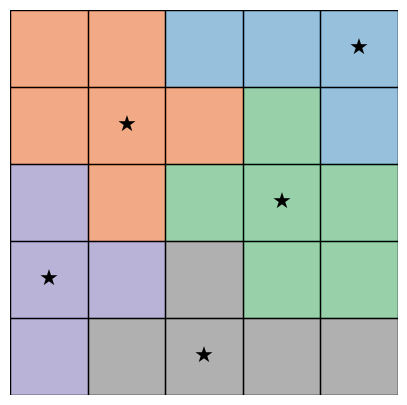

In [18]:
solution5 = generate_star_solution(5)
puzzle5 = generate_regions(solution5)
visualize_star_battle(puzzle5, solution5)

[['A' 'A' 'B' 'B' 'B' 'C' 'C' 'D' 'D' 'D']
 ['A' 'A' 'B' 'B' 'B' 'C' 'C' 'D' 'D' 'D']
 ['A' 'A' 'B' 'B' 'B' 'C' 'C' 'D' 'D' 'D']
 ['A' 'A' 'B' 'B' 'C' 'C' 'C' 'C' 'D' 'D']
 ['A' 'E' 'E' 'E' 'E' 'C' 'C' 'C' 'D' 'G']
 ['H' 'H' 'E' 'E' 'E' 'F' 'F' 'F' 'G' 'G']
 ['H' 'H' 'H' 'I' 'I' 'F' 'F' 'F' 'G' 'G']
 ['H' 'H' 'H' 'I' 'I' 'F' 'F' 'F' 'F' 'G']
 ['H' 'H' 'H' 'I' 'I' 'J' 'F' 'F' 'F' 'G']
 ['H' 'H' 'H' 'I' 'I' 'J' 'J' 'J' 'J' 'G']]
[[1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]]


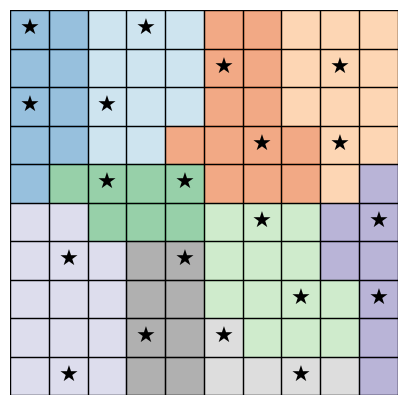

In [19]:
solution10 = generate_star_solution(10)
puzzle10 = generate_regions3(solution10)
print(puzzle10)
print(solution10)
visualize_star_battle(puzzle10, solution10)


[['A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'D' 'D' 'C' 'C' 'C']
 ['A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'D' 'D' 'C' 'C' 'C']
 ['A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'D' 'D' 'C' 'C' 'C']
 ['A' 'A' 'A' 'E' 'E' 'B' 'B' 'B' 'B' 'D' 'D' 'D' 'D' 'C']
 ['G' 'G' 'E' 'E' 'E' 'E' 'E' 'B' 'B' 'D' 'D' 'D' 'F' 'F']
 ['G' 'G' 'E' 'E' 'E' 'E' 'H' 'H' 'H' 'F' 'F' 'F' 'F' 'F']
 ['G' 'G' 'E' 'E' 'H' 'H' 'H' 'H' 'H' 'I' 'F' 'F' 'F' 'F']
 ['G' 'G' 'E' 'E' 'H' 'H' 'H' 'H' 'H' 'I' 'I' 'I' 'F' 'F']
 ['G' 'G' 'J' 'J' 'J' 'J' 'K' 'H' 'I' 'I' 'I' 'I' 'I' 'F']
 ['G' 'G' 'J' 'J' 'J' 'K' 'K' 'I' 'I' 'I' 'I' 'I' 'L' 'L']
 ['G' 'G' 'J' 'J' 'K' 'K' 'K' 'K' 'I' 'I' 'L' 'L' 'L' 'L']
 ['G' 'N' 'J' 'N' 'K' 'K' 'K' 'K' 'M' 'M' 'L' 'L' 'L' 'L']
 ['N' 'N' 'N' 'N' 'N' 'N' 'K' 'M' 'M' 'M' 'L' 'L' 'L' 'L']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'M' 'M' 'M' 'M' 'M' 'L' 'L']]
[[0 1 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 1 0 1 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 

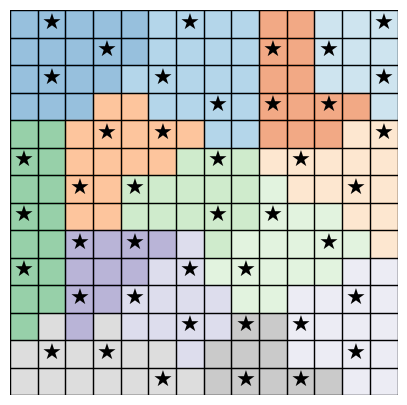

In [20]:
solution14 = generate_star_solution(14)
puzzle14 = generate_regions3(solution14)
print(puzzle14)
print(solution14)
visualize_star_battle(puzzle14, solution14)


In [21]:
print(f"the solution is {validate_solution(puzzle14, puzzle14)}")

row col or region wrong no stars
the solution is False


## new method works better

In [22]:
def layout(grid_size=10, num_regions=10):
# random region layout with minimum 3 cells in a region
    grid = np.full((grid_size, grid_size), -1) 

    # place initial 3 cell regions
    region_seeds = [] 
    used_positions = set()  # to avoid overlapping regions

    for i in range(num_regions):
        while True:
            # Pick a random starting cell
            r, c = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            direction = random.choice([(0, 1), (1, 0)])  # (0,1) = horizontal, (1,0) = vertical

            # compute 3-cell region
            cells = [(r + direction[0] * j, c + direction[1] * j) for j in range(3)]

            # checks all cells are within bounds and not overlapping
            if all(0 <= nr < grid_size and 0 <= nc < grid_size and (nr, nc) not in used_positions for nr, nc in cells):
                for nr, nc in cells:
                    grid[nr, nc] = i  # assigns region ID
                    used_positions.add((nr, nc))
                    region_seeds.append((nr, nc))  # adds each part of the seed for later expansion
                break  # exits loop when valid seed region is found

    # expands all regions with flood fill
    def get_neighbors(r, c):
        neighbors = []
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < grid_size and 0 <= nc < grid_size and grid[nr, nc] == -1:
                neighbors.append((nr, nc))
        return neighbors

    cells_to_expand = region_seeds[:]  # start expanding from the initial 3-cell regions
    while cells_to_expand:
        r, c = cells_to_expand.pop(random.randint(0, len(cells_to_expand) - 1))
        neighbors = get_neighbors(r, c)
        if neighbors:
            random.shuffle(neighbors)
            for nr, nc in neighbors:
                grid[nr, nc] = grid[r, c]  # expand current region
                cells_to_expand.append((nr, nc))  # continue expansion

    return grid

In [23]:
print(layout())

[[9 4 4 4 3 3 3 3 3 3]
 [9 4 4 2 3 3 3 6 6 6]
 [9 9 4 2 2 3 8 6 6 6]
 [9 9 2 2 2 2 8 8 6 7]
 [9 9 2 2 2 2 8 7 7 7]
 [9 9 9 2 2 2 7 7 7 7]
 [9 1 1 2 2 2 7 7 7 7]
 [1 1 1 1 1 5 7 7 7 7]
 [1 1 1 1 1 5 5 0 0 0]
 [1 1 1 1 1 5 5 0 0 0]]


check if the random regions are a solvable star battle

In [24]:
def puzzle_solver(puzzle: np.ndarray):
    height, width = puzzle.shape
    assert height == 10 and width == 10, "Puzzle must be a 10x10 grid"

    # Create a 10x10 grid of integer variables
    grid = [[z3.Int(f"grid_{i}_{j}") for j in range(10)] for i in range(10)]

    def solve_with_constraints(extra_constraints=[]):
        solver = z3.Solver()

        # Each cell can be either 0 (empty) or 1 (star)
        for i in range(10):
            for j in range(10):
                solver.add(z3.Or(grid[i][j] == 0, grid[i][j] == 1))

        # Each row must contain exactly 2 stars
        for i in range(10):
            solver.add(z3.Sum([grid[i][j] for j in range(10)]) == 2)

        # Each column must contain exactly 2 stars
        for j in range(10):
            solver.add(z3.Sum([grid[i][j] for i in range(10)]) == 2)

        # Each region must contain exactly 2 stars
        num_regions = np.max(puzzle) + 1
        for region_id in range(num_regions):
            region_cells = [grid[i][j] for i in range(10) for j in range(10) if puzzle[i, j] == region_id]
            solver.add(z3.Sum(region_cells) == 2)

        # No adjacent stars (orthogonally or diagonally)
        for i in range(10):
            for j in range(10):
                neighbors = [
                    (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1),  # Orthogonal
                    (i - 1, j - 1), (i - 1, j + 1), (i + 1, j - 1), (i + 1, j + 1)  # Diagonal
                ]
                for ni, nj in neighbors:
                    if 0 <= ni < 10 and 0 <= nj < 10:
                        solver.add(z3.Or(grid[i][j] == 0, grid[ni][nj] == 0))

        # Apply additional constraints if provided
        for constraint in extra_constraints:
            solver.add(constraint)

        # Solve the puzzle
        if solver.check() == z3.sat:
            model = solver.model()
            solution = np.array([[model[grid[i][j]].as_long() for j in range(10)] for i in range(10)])
            return solution, model
        else:
            return None, None  # No solution found

    # Solve once to get a solution
    solution, model = solve_with_constraints()
    if solution is None:
        return None  # No solution exists

    # Add a constraint to block this solution
    block_solution = z3.Or([grid[i][j] != model[grid[i][j]] for i in range(10) for j in range(10)])

    # Solve again to check if another solution exists
    _, second_model = solve_with_constraints([block_solution])

    if second_model is not None:
        return None  # More than one solution exists

    return solution  # Unique solution found


In [25]:
layout1 = layout()
solution = puzzle_solver(layout1)
print(solution)

while True:
    puzzle = layout()
    solution = puzzle_solver(puzzle)
    print(solution)
    if solution is not None:
        print("\nSolvable layout found!")
        print("Puzzle layout:")
        print(puzzle)
        print("\nSolved puzzle:")
        print(solution)
        break  # Exit loop when a solvable layout is found



None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [26]:
print(puzzle)
print(solution)


[[6 5 5 5 5 7 7 7 7 7]
 [6 6 6 5 5 7 7 7 7 7]
 [6 6 6 5 5 1 1 1 1 1]
 [9 5 5 5 5 5 1 1 1 1]
 [9 9 9 9 9 9 4 1 0 1]
 [9 9 8 9 4 4 4 0 0 0]
 [9 8 8 3 3 3 4 0 0 0]
 [8 8 8 3 3 3 4 0 0 2]
 [3 3 3 3 3 3 3 0 2 2]
 [3 3 3 3 3 3 3 2 2 2]]
[[0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 0 0]]


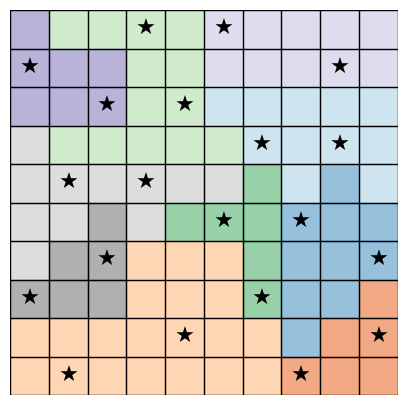

In [27]:
visualize_star_battle(puzzle, solution)

1.4 Storing and compiling puzzles

In [28]:
num_puzzles = 20
puzzles = []
solutions = []
unique_puzzles = set()

while len(puzzles) < num_puzzles:
    layout1 = layout()
    solution = puzzle_solver(layout1)
    
    if solution is not None:
        layout_str = ''.join(map(str, layout1.flatten()))  # Flatten and convert to string
        
        if layout_str not in unique_puzzles:
            puzzles.append(layout1)
            solutions.append(solution)
            unique_puzzles.add(layout_str)
    
    if len(puzzles) > 0 and len(puzzles) % 1 == 0:  
        print(f"Collected {len(puzzles)} puzzles...")

# Save the dataset
np.savez_compressed("star_battle_dataset.npz", puzzles=np.array(puzzles), solutions=np.array(solutions))
print("Dataset saved successfully!")


KeyboardInterrupt: 

In [29]:
# Load the dataset
data = np.load("star_battle_dataset.npz", allow_pickle=True)

# Extract the puzzles and solutions
puzzles = data["puzzles"]
solutions = data["solutions"]

# Print a few puzzles for verification
print(f"Total puzzles loaded: {len(puzzles)}")

for i in range(min(5, len(puzzles))):  # Print only the first 5 for readability
    print(f"\nPuzzle {i + 1}:")
    print(puzzles[i])  # Print the stored puzzle grid
    print("\nSolution:")
    print(solutions[i])  # Print the corresponding solution grid

Total puzzles loaded: 20

Puzzle 1:
[[9 1 1 1 1 7 7 7 7 7]
 [9 9 1 1 1 7 7 7 7 7]
 [9 9 1 1 1 1 6 7 0 0]
 [9 1 1 1 1 1 6 0 0 0]
 [9 2 1 1 1 6 6 0 0 0]
 [2 2 8 8 3 3 6 0 0 0]
 [2 2 8 8 3 3 3 4 0 0]
 [2 2 8 4 4 4 4 4 4 4]
 [2 2 8 5 5 5 5 4 4 4]
 [2 2 5 5 5 5 5 4 4 4]]

Solution:
[[0 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0 0 0 0]]

Puzzle 2:
[[1 1 1 1 6 6 6 6 6 6]
 [1 1 1 7 6 6 6 6 6 5]
 [1 1 1 7 0 0 0 0 5 5]
 [1 1 1 7 3 0 4 5 5 5]
 [1 1 1 3 3 3 4 5 5 5]
 [1 3 3 3 3 3 4 4 5 5]
 [3 3 3 3 2 2 4 4 4 4]
 [3 3 3 3 2 2 4 4 9 9]
 [8 8 8 3 2 2 2 9 9 9]
 [8 8 8 8 2 2 2 2 9 9]]

Solution:
[[0 0 0 0 0 1 0 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0]
 [1 0 1 0 0 0 0 0 0 0]]

Puzzle

In [32]:
def visualize_star_battle(puzzle, solution=None):
    size = len(puzzle)
    
    # Convert NumPy array to list if necessary
    if isinstance(puzzle, np.ndarray):
        puzzle = puzzle.tolist()
    if solution is not None and isinstance(solution, np.ndarray):
        solution = solution.tolist()

    fig, ax = plt.subplots(figsize=(5, 5))

    # Create a grid
    for x in range(size + 1):
        ax.plot([x, x], [0, size], 'k', lw=1)  # Vertical lines
        ax.plot([0, size], [x, x], 'k', lw=1)  # Horizontal lines

    # Fill in regions with colors
    region_colors = {}
    color_map = plt.cm.tab20c
    unique_regions = sorted(set(cell for row in puzzle for cell in row))

    for idx, region in enumerate(unique_regions):
        region_colors[region] = color_map(idx / len(unique_regions))

    for row in range(size):
        for col in range(size):
            region = puzzle[row][col]
            ax.add_patch(plt.Rectangle((col, size - row - 1), 1, 1, color=region_colors[region], alpha=0.5))
            
            # Add star if solution is provided
            if solution and solution[row][col] == 1:
                ax.text(col + 0.5, size - row - 0.5, '★', fontsize=16, ha='center', va='center', color='black')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.show()


Showing puzzle 7/10


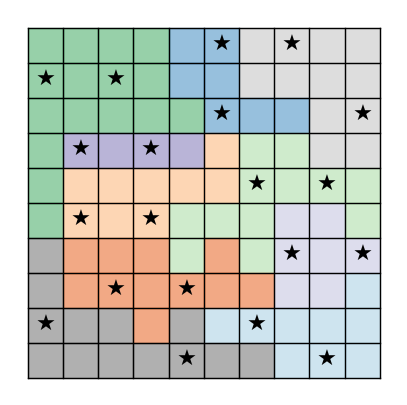

Showing puzzle 5/10


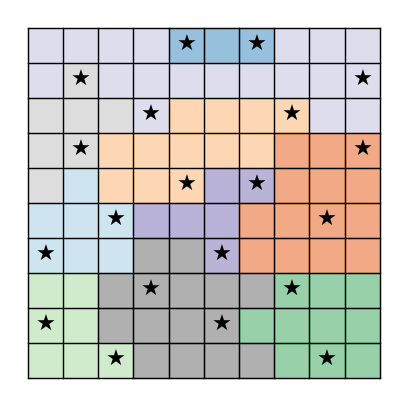

Showing puzzle 2/10


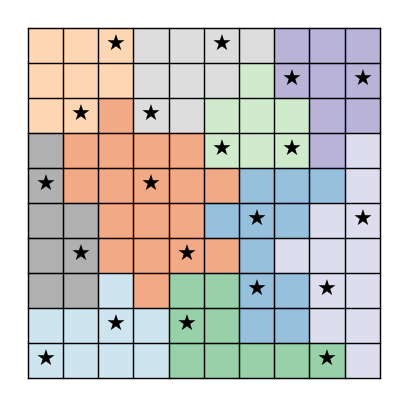

Showing puzzle 8/10


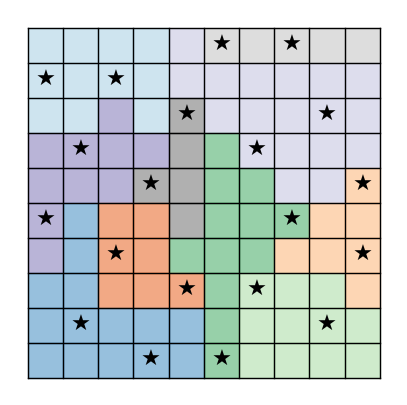

Showing puzzle 6/10


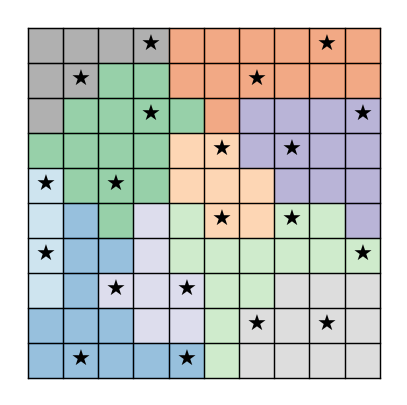

In [ ]:
# Load the dataset
data = np.load("star_battle_dataset.npz", allow_pickle=True)
puzzles = data["puzzles"]
solutions = data["solutions"]

# Pick 5 random indices
some_puzzles = random.sample(range(len(puzzles)), 5)

# Show 5 random puzzles
for i in some_puzzles:
    print(f"Showing puzzle {i+1}/{len(puzzles)}")
    visualize_star_battle(puzzles[i], solutions[i])

1.6 Generate initial test set of puzzles

In [72]:
# generate here as well
num_puzzles = 1000
puzzles = []
solutions = []
unique_puzzles = set()

while len(puzzles) < num_puzzles:
    layout1 = layout()
    solution = puzzle_solver(layout1)
    
    if solution is not None:
        layout_str = ''.join(map(str, layout1.flatten()))  # Flatten and convert to string
        
        if layout_str not in unique_puzzles:
            puzzles.append(layout1)
            solutions.append(solution)
            unique_puzzles.add(layout_str)
    
    if len(puzzles) % 50 == 0:  # Print progress every 100 puzzles
        print(f"Collected {len(puzzles)} puzzles...")

# Save the dataset
np.savez_compressed("star_battle_dataset.npz", puzzles=np.array(puzzles), solutions=np.array(solutions))
print("Dataset saved successfully!")

Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0 puzzles...
Collected 0

Showing puzzle 869/1000


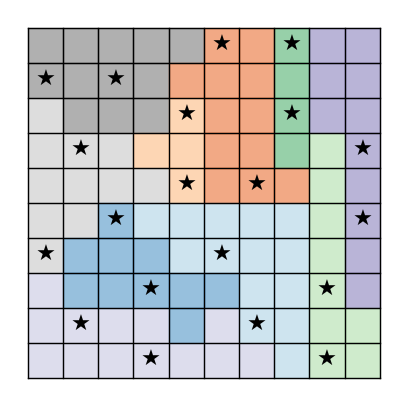

Showing puzzle 456/1000


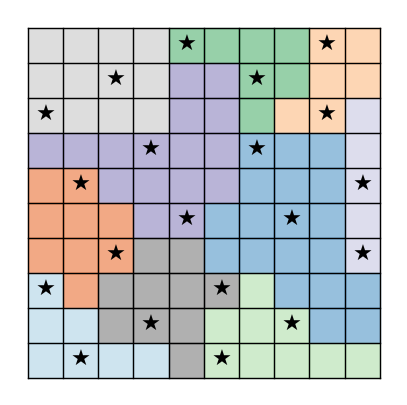

Showing puzzle 43/1000


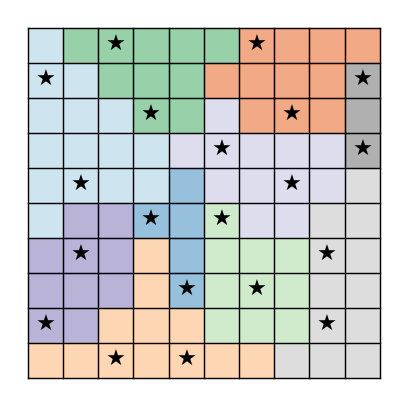

Showing puzzle 965/1000


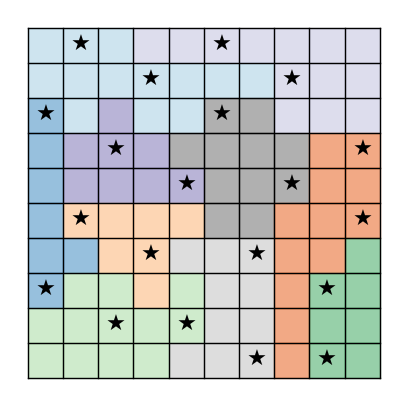

Showing puzzle 199/1000


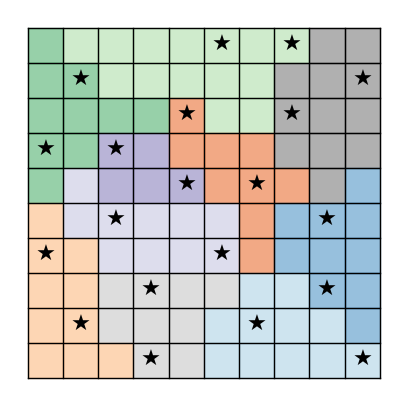

In [75]:
# Load the dataset
data = np.load("star_battle_dataset.npz", allow_pickle=True)
puzzles = data["puzzles"]
solutions = data["solutions"]

# Pick 5 random indices
some_puzzles = random.sample(range(len(puzzles)), 5)

# Show 5 random puzzles
for i in some_puzzles:
    print(f"Showing puzzle {i+1}/{len(puzzles)}")
    visualize_star_battle(puzzles[i], solutions[i])

In [73]:
# Convert puzzles and solutions to lists for JSON compatibility
puzzles_list = [puzzle.tolist() for puzzle in puzzles]
solutions_list = [solution.tolist() for solution in solutions]

# Create a dictionary to store both puzzles and solutions
dataset = {"puzzles": puzzles_list, "solutions": solutions_list}

# Save as JSON
with open("star_battle_dataset.json", "w") as json_file:
    json.dump(dataset, json_file)

print("Dataset saved as JSON successfully!")


Dataset saved as JSON successfully!


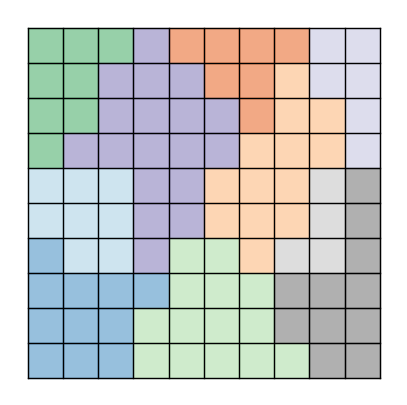

In [34]:
visualize_star_battle(puzzles[19])